# Sun – Compact DM Conversion Notebook
Mirror of the Jupiter/Earth analyses but tailored to the solar environment.


## Setup
Load shared modules and configure the plotting style used across the paper.

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogLocator, LogFormatterSciNotation
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from scipy.interpolate import interp1d

from modules.constants import SecondToInveV
from modules.planet_env import SUN_ENV
from modules.conversion import (
    plasma_freq,
    specific_brightness,
    spectral_flux_density,
    beam_filling_factor,
    resonance_radius,
)
from modules.noise import (
    ma_to_freq,
    freq_to_ma,
    galactic_background,
    brightness_qtn_sun,
    noise_rms,
)

plot_factor = 2
font_size = plot_factor * 9
lw_fixed = plot_factor * 1
column_width = plot_factor * 3.375
fig_width = column_width
fig_height = fig_width * 0.75

plt.rcParams.update({
    "text.usetex": True,
    "font.size": font_size,
    "axes.titlesize": font_size,
    "axes.labelsize": font_size,
    "xtick.labelsize": font_size,
    "ytick.labelsize": font_size,
    "legend.fontsize": font_size,
    "figure.titlesize": font_size,
    "font.family": "serif",
    "text.latex.preamble": r"\usepackage{amsmath}"
})


## Physical profiles
Solar density, magnetic-profile, and plasma-frequency diagnostics.

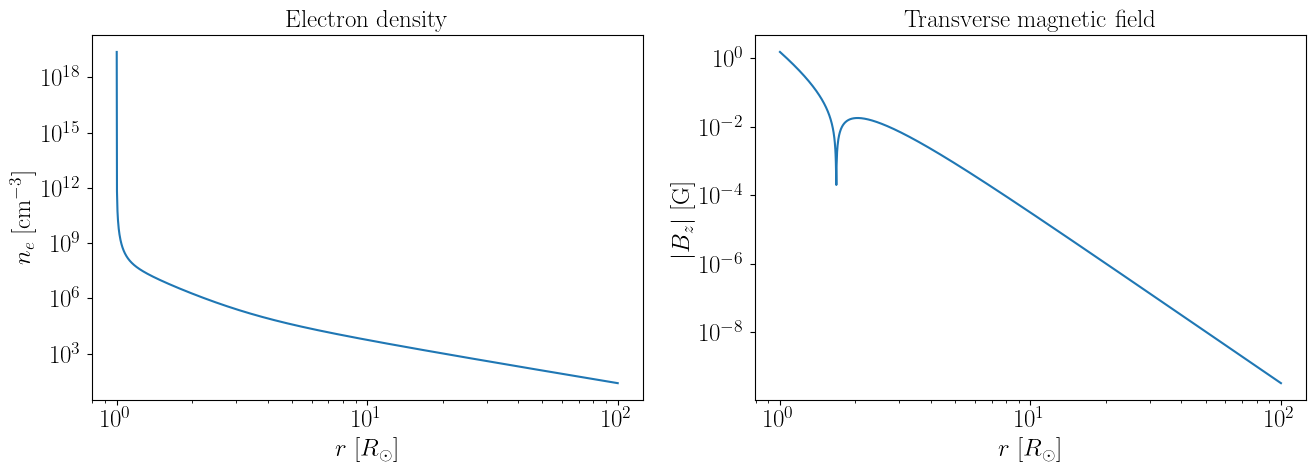

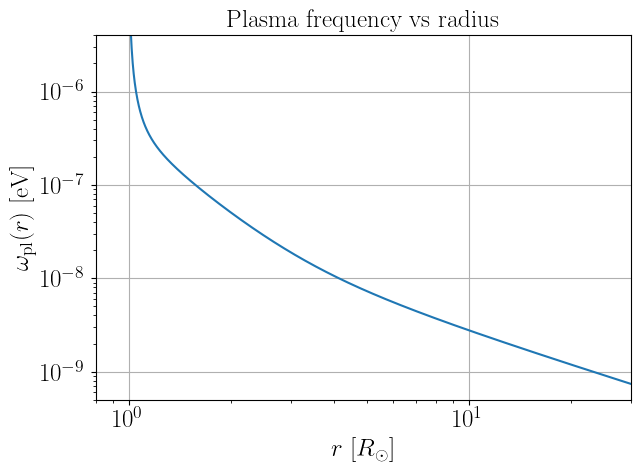

In [21]:
r_vals = np.logspace(0.0, 2.0, 2000)
h_km = (r_vals - 1.0) * SUN_ENV.radius_km
ne_cm3 = SUN_ENV.density_profile(h_km)
B_gauss = SUN_ENV.magnetic_profile(h_km)
omega_pl = plasma_freq(ne_cm3)

fig, ax = plt.subplots(1, 2, figsize=(2 * fig_width, fig_height))
ax[0].plot(r_vals, ne_cm3)
ax[0].set_xscale('log'); ax[0].set_yscale('log')
ax[0].set_xlabel(r'$r$ [$R_\odot$]')
ax[0].set_ylabel(r'$n_e$ [cm$^{-3}$]')
ax[0].set_title('Electron density')

ax[1].plot(r_vals, np.abs(B_gauss))
ax[1].set_xscale('log'); ax[1].set_yscale('log')
ax[1].set_xlabel(r'$r$ [$R_\odot$]')
ax[1].set_ylabel(r'$|B_z|$ [G]')
ax[1].set_title('Transverse magnetic field')

fig.tight_layout(); plt.show()

fig, ax = plt.subplots(figsize=(fig_width, fig_height))
ax.plot(r_vals, omega_pl)
ax.set_xscale('log'); ax.set_yscale('log')
ax.set_xlabel(r'$r$ [$R_\odot$]'); ax.set_ylabel(r'$\omega_{\rm pl}(r)$ [eV]')
ax.set_title('Plasma frequency vs radius')

plt.ylim(5e-10, 4e-6)
plt.xlim(8e-1, 3e1)
plt.grid(True)

plt.tight_layout(); plt.show()


In [22]:
ma_min = 1e-10  # eV, instrument sensitivity constraint
ma_max = float(freq_to_ma(1e8))  # eV, instrument sensitivity constraint

## Flux grids
Axion and dark-photon fluxes (bandwidth-averaged) evaluated on mass–coupling grids, with fixed distance and bandwidth. Then saved in .npz file

In [23]:
m_a_vals = np.logspace(-10, -5, 200)
g_vals = np.logspace(-15, -8, 200)
epsilon_vals = np.logspace(-18, -10, 200)

M, G = np.meshgrid(m_a_vals, g_vals, indexing='xy')
M_eps, EPS = np.meshgrid(m_a_vals, epsilon_vals, indexing='xy')

In [24]:
bandwidth_hz = 1e3
AU_m = 1.496e11
D_1AU_m = 1.0 * AU_m

F_axion = spectral_flux_density(SUN_ENV, M, G, distance_m=D_1AU_m, bandwidth_Hz=bandwidth_hz, species='axion')
F_dp = spectral_flux_density(SUN_ENV, M_eps, EPS, distance_m=D_1AU_m, bandwidth_Hz=bandwidth_hz, species='dp')

rc_vals = resonance_radius(SUN_ENV, m_a_vals) * 1e3
np.savez(
    'grids/flux_grids_sun_compact.npz',
    m_a_vals=m_a_vals,
    g_vals=g_vals,
    epsilon_vals=epsilon_vals,
    F_axion=F_axion,
    F_dp=F_dp,
    rc_vals=rc_vals,
    distance_m=D_1AU_m,
    bandwidth_hz=bandwidth_hz,
)
print('Saved flux grids to flux_grids_sun_compact.npz')


Saved flux grids to flux_grids_sun_compact.npz


## Flux vs. distance
Normalized flux for fixed couplings as a function of observer distance.

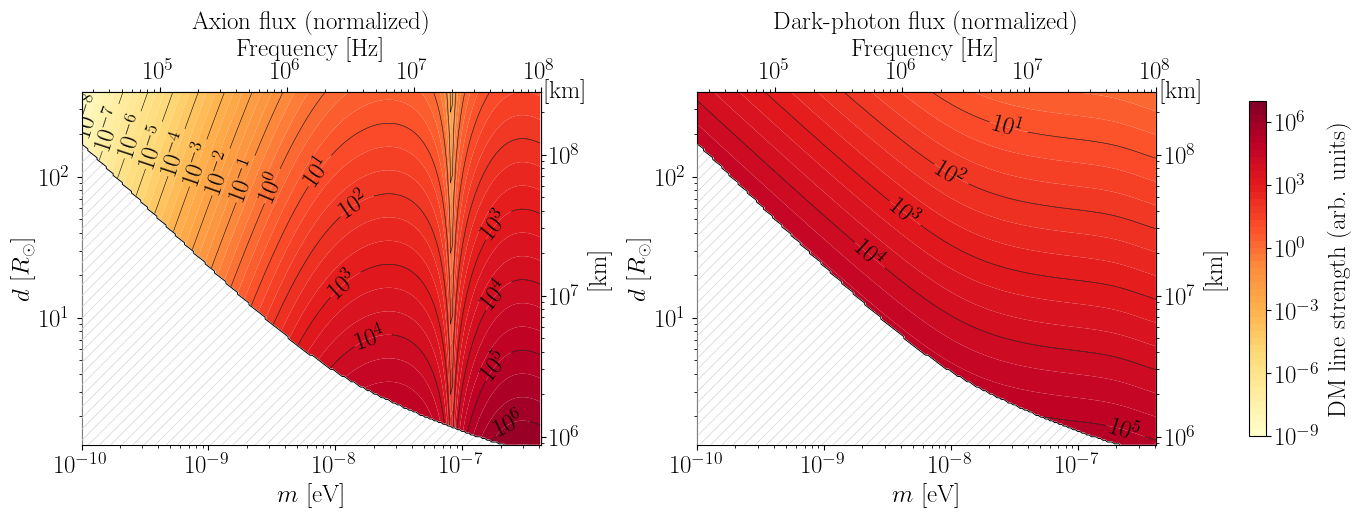

In [25]:
R_S_m = SUN_ENV.radius_m
g_fixed = 1e-10
eps_fixed = 1e-15
bandwidth_line = 1.0

d_vals = np.logspace(0.1, 2.6, 200) * R_S_m
m_a_vals_d = np.logspace(np.log10(ma_min*1.01), np.log10(ma_max*0.99), 200)
M_d, D = np.meshgrid(m_a_vals_d, d_vals)

def Rs_to_km(rs):
    return rs * SUN_ENV.radius_km

def km_to_Rs(km):
    return km / SUN_ENV.radius_km

def decade_label_jy(v):
    n = int(np.round(np.log10(v)))
    return rf"$10^{{{n}}}$"

F_ax_line = spectral_flux_density(SUN_ENV, M_d, np.full_like(M_d, g_fixed), distance_m=D, bandwidth_Hz=bandwidth_line, species='axion')
F_dp_line = spectral_flux_density(SUN_ENV, M_d, np.full_like(M_d, eps_fixed), distance_m=D, bandwidth_Hz=bandwidth_line, species='dp')

F_ref = 1e-23
F_ax_norm = np.where(F_ax_line > 0, F_ax_line / F_ref, np.nan)
F_dp_norm = np.where(F_dp_line > 0, F_dp_line / F_ref, np.nan)

finite_ax = np.isfinite(F_ax_norm) & (F_ax_norm > 0)
finite_dp = np.isfinite(F_dp_norm) & (F_dp_norm > 0)
common_min = np.nanmin([np.nanmin(F_ax_norm[finite_ax]), np.nanmin(F_dp_norm[finite_dp])])
common_max = np.nanmax([np.nanmax(F_ax_norm[finite_ax]), np.nanmax(F_dp_norm[finite_dp])])
vmin = 10.0 ** np.floor(np.log10(common_min))
vmax = 10.0 ** np.ceil(np.log10(common_max))

def filled_contour_with_decades(ax, X, Y, Z, vmin, vmax, cmap='YlOrRd', nlevels=3 * (int(np.log10(vmax/vmin)) + 1) - 2, title=None):
    finite = np.isfinite(Z) & (Z > 0)
    if not np.any(finite):
        raise ValueError("No valid values for contour.")

    levels_filled = np.logspace(np.log10(vmin), np.log10(vmax), nlevels)
    cf = ax.contourf(
        X, Y, Z,
        levels=levels_filled,
        norm=LogNorm(vmin=vmin, vmax=vmax),
        cmap=cmap,
        antialiased=True,
    )

    mask_valid = np.isfinite(Z) & (Z > 0)
    ax.contour(X, Y, mask_valid, levels=[0.5], colors='k', linestyles='-', linewidths=0.7, zorder=6)
    ax.contourf(X, Y, (~mask_valid).astype(int), levels=[0.5, 1.5], colors='white', alpha=0.5, zorder=4)
    with plt.rc_context({'hatch.color': 'lightgray', 'hatch.linewidth': 0.5}):
        ax.contourf(
            X, Y, (~mask_valid).astype(int),
            levels=[0.5, 1.5], colors='none', hatches=['///'], zorder=5,
        )

    n_lo = int(np.floor(np.log10(vmin)))
    n_hi = int(np.ceil(np.log10(vmax)))
    levels_lines = 10.0 ** np.arange(n_lo, n_hi + 1)
    cs = ax.contour(X, Y, Z, levels=levels_lines, colors='k', linewidths=0.4)

    manual_positions = []
    x_excl_low, x_excl_high = 5e-8, 1.3e-7
    for level_segs in cs.allsegs:
        for seg in level_segs:
            if seg.size == 0:
                continue
            mask = (seg[:, 0] < x_excl_low) | (seg[:, 0] > x_excl_high)
            if np.any(mask):
                xy = seg[mask]
                idx = xy.shape[0] // 2
                manual_positions.append((xy[idx, 0], xy[idx, 1]))

    if manual_positions:
        ax.clabel(
            cs,
            fmt=decade_label_jy,
            inline=True,
            fontsize=font_size,
            manual=manual_positions,
        )
    else:
        ax.clabel(cs, fmt=decade_label_jy, inline=True, fontsize=font_size)

    if title:
        ax.set_title(title)

    return cf

fig, axes = plt.subplots(1, 2, figsize=(2 * fig_width, fig_height), constrained_layout=True)

axes[0].set_xscale('log'); axes[0].set_yscale('log')
axes[0].set_xlabel(r"$m$ [eV]"); axes[0].set_ylabel(r"$d$ [$R_\odot$]")
axes[0].set_xlim(ma_min, ma_max)
cf0 = filled_contour_with_decades(axes[0], M_d, D / R_S_m, F_ax_norm, vmin, vmax, cmap='YlOrRd', title='Axion flux (normalized)')
secax0 = axes[0].secondary_xaxis('top', functions=(ma_to_freq, freq_to_ma))
secax0.set_xlabel('Frequency [Hz]'); secax0.set_xscale('log')
secax0.xaxis.set_major_locator(LogLocator(base=10.0))
secax0.xaxis.set_minor_locator(LogLocator(base=10.0, subs='auto', numticks=12))
secax0.xaxis.set_major_formatter(LogFormatterSciNotation(labelOnlyBase=False))
secay0 = axes[0].secondary_yaxis('right', functions=(Rs_to_km, km_to_Rs))
secay0.set_ylabel('[km]')

axes[1].set_xscale('log'); axes[1].set_yscale('log')
axes[1].set_xlabel(r"$m$ [eV]"); axes[1].set_ylabel(r"$d$ [$R_\odot$]")
axes[1].set_xlim(ma_min, ma_max)
cf1 = filled_contour_with_decades(axes[1], M_d, D / R_S_m, F_dp_norm, vmin, vmax, cmap='YlOrRd', title='Dark-photon flux (normalized)')
secax1 = axes[1].secondary_xaxis('top', functions=(ma_to_freq, freq_to_ma))
secax1.set_xlabel('Frequency [Hz]'); secax1.set_xscale('log')
secax1.xaxis.set_major_locator(LogLocator(base=10.0))
secax1.xaxis.set_minor_locator(LogLocator(base=10.0, subs='auto', numticks=12))
secax1.xaxis.set_major_formatter(LogFormatterSciNotation(labelOnlyBase=False))
secay1 = axes[1].secondary_yaxis('right', functions=(Rs_to_km, km_to_Rs))
secay1.set_ylabel('[km]')

for ax in axes:
    ax.grid(True, which='both', ls=':', alpha=0)
    ax.text(1.01, 0.97, '[km]', transform=ax.transAxes, ha='left', va='bottom')

cbar = fig.colorbar(cf1, ax=axes.ravel().tolist(), shrink=0.95, pad=0.02)
cbar.set_label(r'DM line strength (arb. units)')
cbar.locator = LogLocator(base=10)
cbar.update_ticks()

plt.show()


## Noise model
Galactic background plus QTN at 0.28 AU with RMS estimate.

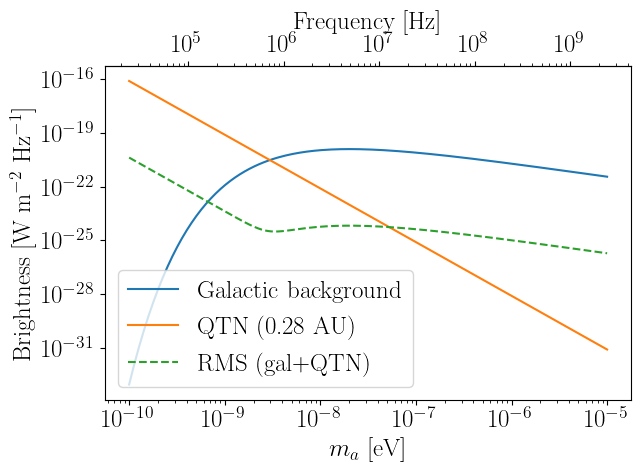

In [26]:
bandwidth_noise = 1e3
integration_hours = 100
gal_brightness = galactic_background(m_a_vals)
qtn_brightness = brightness_qtn_sun(m_a_vals, r_AU=0.28)
noise_total = gal_brightness + qtn_brightness
rms_noise = noise_rms(noise_total, bandwidth_noise, integration_hours)

fig, ax = plt.subplots(figsize=(fig_width, fig_height))
ax.plot(m_a_vals, gal_brightness, label='Galactic background')
ax.plot(m_a_vals, qtn_brightness, label='QTN (0.28 AU)')
ax.plot(m_a_vals, rms_noise, '--', label='RMS (gal+QTN)')
ax.set_xscale('log'); ax.set_yscale('log')
ax.set_xlabel(r'$m_a$ [eV]'); ax.set_ylabel(r'Brightness [W m$^{-2}$ Hz$^{-1}$]')
ax.legend()
secax = ax.secondary_xaxis('top', functions=(ma_to_freq, freq_to_ma))
secax.set_xlabel('Frequency [Hz]'); secax.set_xscale('log')
secax.xaxis.set_major_locator(LogLocator(base=10.0))
secax.xaxis.set_minor_locator(LogLocator(base=10.0, subs='auto', numticks=12))
secax.xaxis.set_major_formatter(LogFormatterSciNotation(labelOnlyBase=False))
plt.tight_layout(); plt.show()


In [27]:
def rms_gal_qtn(ma_vals, d_Rsun, bandwidth_hz=1e3, time_hours=100):
    qtn = brightness_qtn_sun(ma_vals, r_Rsun=d_Rsun)
    return noise_rms(gal_brightness + qtn, bandwidth_hz, time_hours)

## Sensitivity curves
Distance-dependent sensitivity derived from the noise model and beam filling.

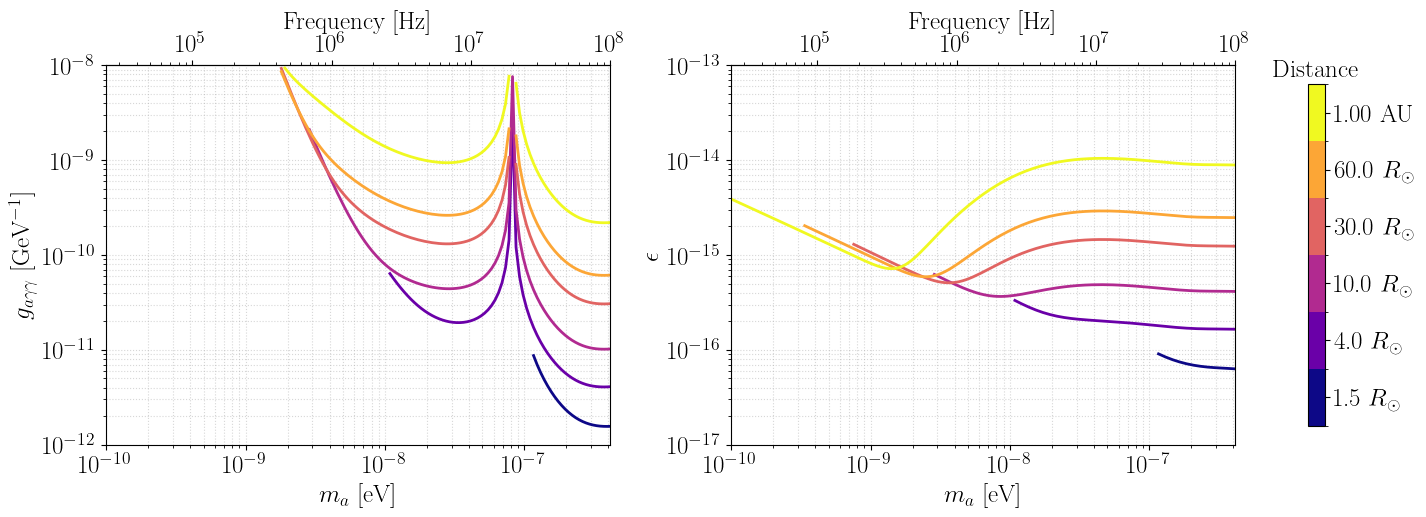

In [28]:
SNR = 2
bandwidth_noise = 1e3
integration_hours = 100

B_ax = specific_brightness(SUN_ENV, M, G, bandwidth_noise, species='axion')
B_dp = specific_brightness(SUN_ENV, M_eps, EPS, bandwidth_noise, species='dp')

distances_Rsun = [1.5, 4, 10, 30, 60, 215]
labels = []
for i, d in enumerate(distances_Rsun):
    if i < len(distances_Rsun) - 1:
        labels.append(fr"{d:.1f} $R_\odot$")
    else:
        labels.append(fr"{d * SUN_ENV.radius_m / 1.496e11:.2f} AU")

cmap = plt.colormaps['plasma'].resampled(len(distances_Rsun))
norm = mcolors.BoundaryNorm(range(len(distances_Rsun) + 1), cmap.N)

fig, axes = plt.subplots(1, 2, figsize=(2.1 * fig_width, fig_height), constrained_layout=True)

for i, d_Rsun in enumerate(distances_Rsun):
    d_m = d_Rsun * SUN_ENV.radius_m
    rms_vals = rms_gal_qtn(m_a_vals, d_Rsun, bandwidth_hz=bandwidth_noise, time_hours=integration_hours)
    phi = beam_filling_factor(SUN_ENV, m_a_vals, d_m, invalid='nan')

    g_curve = []
    for j in range(len(m_a_vals)):
        if not np.isfinite(phi[j]) or phi[j] <= 0:
            g_curve.append(np.nan)
            continue
        sig_col = B_ax[:, j] * phi[j]
        mask = np.isfinite(sig_col) & (sig_col > 0)
        if mask.sum() < 2:
            g_curve.append(np.nan)
            continue
        interp = interp1d(np.log10(sig_col[mask]), np.log10(g_vals[mask]), bounds_error=False, fill_value=np.nan)
        tgt = SNR * rms_vals[j]
        if not np.isfinite(tgt) or tgt <= 0:
            g_curve.append(np.nan)
            continue
        g_curve.append(10 ** interp(np.log10(tgt)))
    axes[0].plot(m_a_vals, g_curve, color=cmap(i), lw=lw_fixed)

    eps_curve = []
    for j in range(len(m_a_vals)):
        if not np.isfinite(phi[j]) or phi[j] <= 0:
            eps_curve.append(np.nan)
            continue
        sig_col = B_dp[:, j] * phi[j]
        mask = np.isfinite(sig_col) & (sig_col > 0)
        if mask.sum() < 2:
            eps_curve.append(np.nan)
            continue
        interp = interp1d(np.log10(sig_col[mask]), np.log10(epsilon_vals[mask]), bounds_error=False, fill_value=np.nan)
        tgt = SNR * rms_vals[j]
        if not np.isfinite(tgt) or tgt <= 0:
            eps_curve.append(np.nan)
            continue
        eps_curve.append(10 ** interp(np.log10(tgt)))
    axes[1].plot(m_a_vals, eps_curve, color=cmap(i), lw=lw_fixed)

for ax, ylabel in zip(axes, [r'$g_{a\gamma\gamma}$ [GeV$^{-1}$]', r'$\epsilon$']):
    ax.set_xscale('log'); ax.set_yscale('log')
    ax.set_xlabel(r'$m_a$ [eV]'); ax.set_ylabel(ylabel)
    ax.set_xlim(1e-10, freq_to_ma(1e8))
    ax.grid(True, which='both', ls=':', alpha=0.5)
    ax.yaxis.set_major_locator(LogLocator(base=10.0, numticks=20))
    ax.yaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1, numticks=20))

axes[0].set_ylim(1e-12, 1e-8)
axes[1].set_ylim(1e-17, 1e-13)

secax0 = axes[0].secondary_xaxis('top', functions=(ma_to_freq, freq_to_ma))
secax0.set_xlabel('Frequency [Hz]'); secax0.set_xscale('log')
secax1 = axes[1].secondary_xaxis('top', functions=(ma_to_freq, freq_to_ma))
secax1.set_xlabel('Frequency [Hz]'); secax1.set_xscale('log')

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=axes.ravel().tolist(), ticks=np.arange(len(distances_Rsun)) + 0.5, location='right', shrink=0.9)
cbar.ax.set_yticklabels(labels)
cbar.ax.set_title('Distance', pad=6)

plt.show()
